In [1]:
%matplotlib inline

from datetime import datetime
import backtrader as bt
import backtrader.feeds as btfeeds
import yfinance as yf
import tulipy as ta
import matplotlib.pyplot as plt
import tiingo
import pandas as pd 
import pyfolio as pf
import math
import numpy as np

# QuantStats

In [2]:
class QuantConnectCSVData(btfeeds.GenericCSVData):

    params = (
        ('nullvalue', float('NaN')),
        ('dtformat', '%Y:%m:%d'),
        ('datetime', 0),
        ('time', 1),
        ('open', 2),
        ('high', 3),
        ('low', 4),
        ('close', 5),
        ('volume', 6),
        ('openinterest', -1),
        ('timeframe', bt.TimeFrame.Minutes), 
        ('compression', 240),
    )

In [3]:
class TiingoCSVData(btfeeds.GenericCSVData):
    lines = ('inSPY',)
    
    params = (
        ('nullvalue', float('NaN')),
        ('dtformat', '%Y-%m-%d'),
        ('datetime', 0),
        ('open', 9),
        ('high', 7),
        ('low', 8),
        ('close', 6),
        ('volume', 10),
        ('inSPY', 13),
        ('openinterest', -1),
    )

In [4]:
class RSIt(bt.Strategy):

    params = (('oneplot', True),
                ('tp_multiplier', 5),
                ('sl_multiplier', 3),
                ('ATR_Period', 14),
                ('bk_period', 100),
                )

    def __init__(self):
        self.inds = dict()
        for i, d in enumerate(self.datas):
            self.inds[i] = dict()
            self.inds[i]['ATR']= bt.indicators.AverageTrueRange(d, period=self.p.ATR_Period)
            self.inds[i]['bkhigh'] = bt.indicators.Highest(d,period=self.p.bk_period)
            self.inds[i]['bklow'] = bt.indicators.Lowest(d, period=self.p.bk_period)

            if i > 0:
                if self.p.oneplot == True:
                    d.plotinfo.plotmaster = self.datas[0]

    def next(self):
        for i, d in enumerate(self.datas):
            dt, dn = self.datetime.date(), d._name
            pos = self.getposition(d).size
            cash = self.broker.getcash()
            dt = self.data.datetime.date()
            if not pos:  # no market / no orders
                if (d.close[0] != 0) and (d.inSPY[0] == 1):
                    if (d.close[0] > self.inds[i]['bkhigh'][-1]):
                        # self.buy(data=d, size=100)                    
                        price = d.close[0]
                        price_limit = price + (self.p.tp_multiplier*self.inds[i]['ATR'][0])
                        price_stop = price - (self.p.sl_multiplier*self.inds[i]['ATR'][0])
                        qty = round((cash*0.01)/(price - price_stop))

                        if qty != 0:    
                            self.buy_bracket(
                                data=d,
                                size=qty,
                                exectype=bt.Order.Market,
                                limitprice=price_limit,
                                price=price,
                                stopprice=price_stop,
                                )

                    elif (d.close[0] < self.inds[i]['bklow'][-1]):
                        # self.sell(data=d, size=100)

                        price = d.close[0]
                        price_limit = price - (self.p.tp_multiplier*self.inds[i]['ATR'][0])
                        price_stop = price + (self.p.sl_multiplier*self.inds[i]['ATR'][0])
                        qty = round((cash*0.01)/(price_stop - price))

                        if qty != 0: 
                            self.sell_bracket(
                                    data=d,
                                    price=price,
                                    size=qty,
                                    exectype=bt.Order.Market,
                                    stopprice=price_stop,
                                    limitprice=price_limit,
                                )
                else:
                    pass
            
            elif pos:
                pass
    

#         def stop(self):
#             print('LB Params: {} End value: {}'.format(self.p.bk_period, self.broker.getvalue()))
                
    def notify_trade(self, trade):
        dt = self.data.datetime.date()
        if trade.isclosed:
            print('{} {} Closed: PnL Gross {}, Net {}, Cash left {:.2f}'.format(
                                                dt,
                                                trade.data._name,
                                                round(trade.pnl,2),
                                                round(trade.pnlcomm,2),
                                                self.broker.getcash()))

In [151]:
a

array('d', [90.03, 102.57, 91.48, 91.25, 97.45, 98.55, 124.87, 117.0, 123.8, 140.71, 142.13, 147.81, 152.2, 163.07, 150.09])

In [5]:
class Momentum(bt.Indicator):
    lines = ('pctreturn',)
    params = (('period', 12),)
    
    def __init__(self):
        self.addminperiod(self.params.period)
    
    def next(self):
        a = (self.data.get(ago=0, size=(self.p.period+1)))
        df = pd.DataFrame(a)
#         df_change = ((df.pct_change()+1).cumprod())-1
        df_changes = (df.pct_change()).mean()
        self.lines.pctreturn[0] = df_changes*100

In [6]:
class Test(bt.Strategy):
    
    params = (('period', 12),
            )
    
    def __init__(self):
        self.inds = dict()
        for i, d in enumerate(self.datas):
            self.inds[i] = dict()
            self.inds[i]['Momen']= Momentum(d, period=self.p.period)

    def next(self):
        dt = self.data.datetime.date()
        for i,d in enumerate(self.datas):
            print('Ticker: {} Time: {}, Price: {:2f}, and Returns: {:.4f}'.format(d._name, dt, d.close[0], self.inds[i]['Momen'][0]))

In [18]:
class TestStrat(bt.Strategy):
    
    params = (('text', 1),
              ('period', 12),
            )
    
    def __init__(self):
        self.i = 0
        self.inds = dict()
        self.spy = self.datas[0]
        self.bil = self.datas[1]
        self.veu = self.datas[2]
        self.agg = self.datas[3]
        self.mospy = Momentum(self.spy, period=self.p.period)
        self.mobil = Momentum(self.bil, period=self.p.period)
        self.moveu = Momentum(self.veu, period=self.p.period)
        self.moagg = Momentum(self.agg, period=self.p.period)
        self.order = None

        
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))


    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled]:
            self.log('Order Canceled')
        
        elif order.status in [order.Margin]:
            self.log('Order Margin')
            
        elif order.status in [order.Rejected]:
            self.log('Order Rejected')

        # Write down: no pending order
        self.order = None
        
    def next(self):
        if self.mospy[0] > self.moveu[0]:
            if self.mospy[0] > self.mobil[0]:
                for i in [1,2,3]:
                    self.order = self.order_target_percent(data=self.datas[i], target=0)
                self.order = self.order_target_percent(data=self.datas[0], target=1)
                
            else:
                for i in [0,1,2]:
                    self.order = self.order_target_percent(data=self.datas[i], target=0)
                self.order = self.order_target_percent(data=self.datas[3], target=1)

        elif self.mospy[0] < self.moveu[0]:
            if self.moveu[0] > self.mobil[0]:
                for i in [0,1,3]:
                    self.order = self.order_target_percent(data=self.datas[i], target=0)
                self.order = self.order_target_percent(data=self.datas[2], target=1)
            else:
                for i in [0,1,2]:
                    self.order = self.order_target_percent(data=self.datas[i], target=0)
                self.order = self.order_target_percent(data=self.datas[3], target=1)

In [34]:
cerebro = bt.Cerebro()

datalist = ["SPY" , "BIL", "VEU", "AGG"]

# Add a strategy
cerebro.addstrategy(TestStrat)
cerebro.addanalyzer(bt.analyzers.PyFolio)

#add datafeeds
for i in range(len(datalist)):
    data = TiingoCSVData(dataname=f'./data/ETFs/{datalist[i]}.csv', fromdate=datetime(2005,1,1),todate=datetime(2020,6,30))
    cerebro.resampledata(data, name=datalist[i], timeframe=bt.TimeFrame.Months)

# cerebro.broker.set_checksubmit(checksubmit=False)
cerebro.broker.set_coc(coc=True)

# Set our desired cash start
cerebro.broker.setcash(100000.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
strats = cerebro.run()
firstStrat = strats[0]

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
2007-04-30, BUY EXECUTED, 65.94
2008-06-30, SELL EXECUTED, 70.27
2008-06-30, BUY EXECUTED, 40.55
2008-07-31, SELL EXECUTED, 37.15
2008-07-31, BUY EXECUTED, 70.13
2009-10-30, SELL EXECUTED, 77.37
2009-10-30, BUY EXECUTED, 31.02
2010-06-30, SELL EXECUTED, 28.49
2010-06-30, BUY EXECUTED, 88.60
2011-05-31, SELL EXECUTED, 112.71
2011-05-31, BUY EXECUTED, 38.91
2011-08-31, SELL EXECUTED, 36.38
2011-08-31, BUY EXECUTED, 107.37
2013-01-31, SELL EXECUTED, 122.25
2013-01-31, BUY EXECUTED, 36.51
2013-02-28, SELL EXECUTED, 37.39
2013-02-28, BUY EXECUTED, 128.50
2015-10-30, SELL EXECUTED, 173.57
2015-10-30, BUY EXECUTED, 96.11
2015-11-30, SELL EXECUTED, 96.17
2015-11-30, BUY EXECUTED, 188.37
2016-03-31, SELL EXECUTED, 176.41
2016-03-31, BUY EXECUTED, 97.66
2016-04-29, SELL EXECUTED, 98.51
2016-04-29, BUY EXECUTED, 188.28
2017-06-30, SELL EXECUTED, 225.76
2017-06-30, BUY EXECUTED, 45.42
2018-06-29, SELL EXECUTED, 49.73
2018-06-29, BUY EXECUTED, 258.17
2019-01-31, 

In [14]:
import os
path = R'.\data'
files = [os.path.splitext(filename)[0] for filename in os.listdir(path)]

In [20]:
%matplotlib inline

In [21]:
%matplotlib widget

cerebro.plot(iplot=False,style='candle', bardown='yellow', volume=False)

[[<Figure size 432x288 with 10 Axes>]]

In [40]:
pyfoliozer = firstStrat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

In [41]:
import quantstats as qs

returns_qs = returns.tz_convert(None)
transactions_qs = transactions.tz_convert(None)
positions_qs = positions.tz_convert(None)

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2005-01-31  2005-01-31
End Period                 2020-06-29  2020-06-29
Risk-Free Rate             0.0%        0.0%
Time in Market             85.0%       98.0%

Cumulative Return          120.35%     268.25%
CAGR%                      5.26%       8.82%
Sharpe                     2.34        3.04
Sortino                    3.33        4.45
Max Drawdown               -19.42%     -50.8%
Longest DD Days            549         1186
Volatility (ann.)          51.67%      65.53%
R^2                        0.52        0.52
Calmar                     0.27        0.17
Skew                       -0.72       -0.72
Kurtosis                   2.6         2.17

Expected Daily %           0.43%       0.7%
Expected Monthly %         0.43%       0.7%
Expected Yearly %          5.06%       8.49%
Kelly Criterion            23.75%      25.82%
Risk of Ruin               0.0%      

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-01-31,2020-03-31,2020-06-29,150,-19.424163,-18.038658
2,2011-05-31,2011-09-30,2012-02-29,274,-17.768677,-11.634822
3,2010-04-30,2010-06-30,2010-12-31,245,-16.993807,-15.313391
4,2015-08-31,2016-02-29,2017-02-28,547,-14.227889,-14.156994
5,2018-10-31,2019-05-31,2019-12-31,426,-13.512618,-13.512612


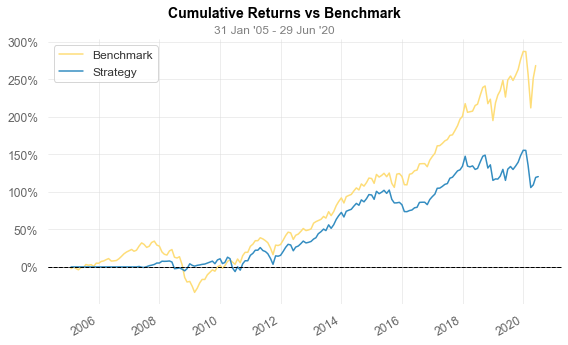

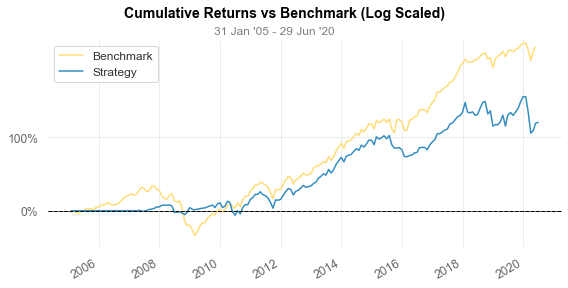

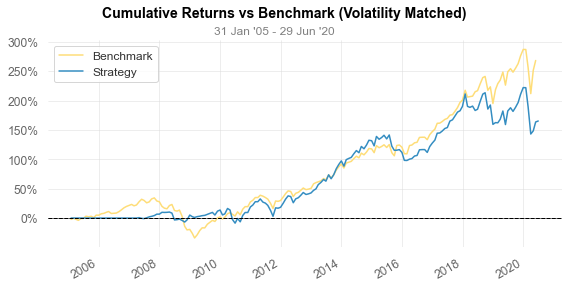

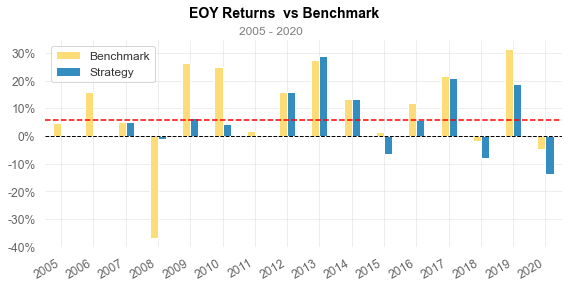

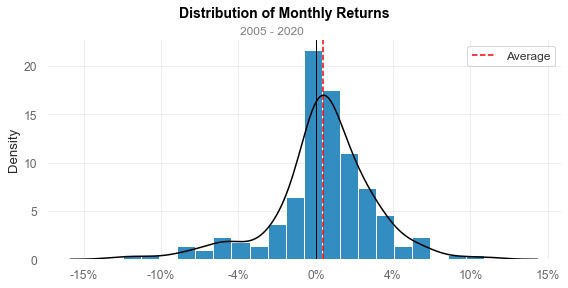

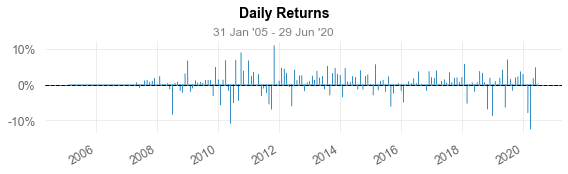

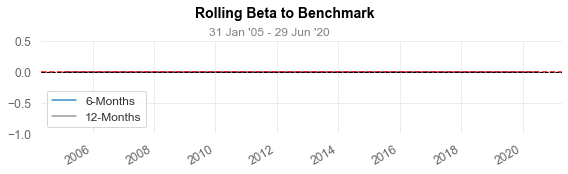

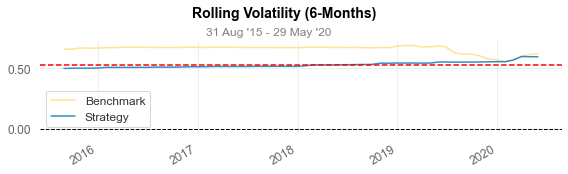

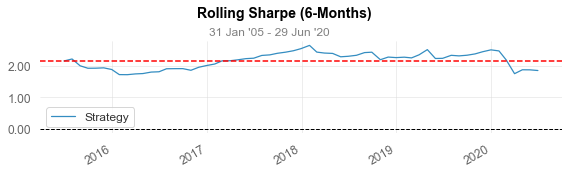

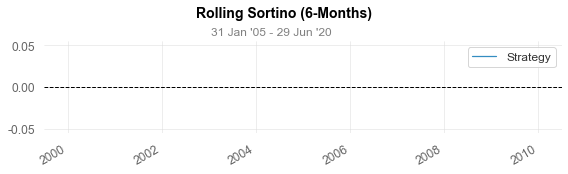

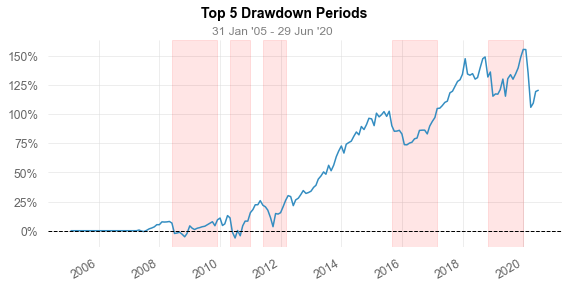

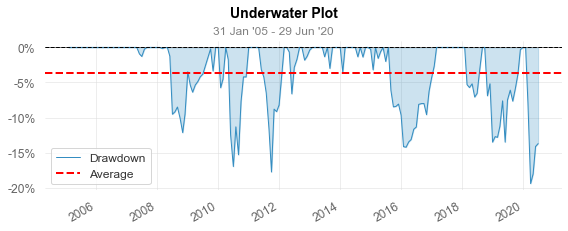

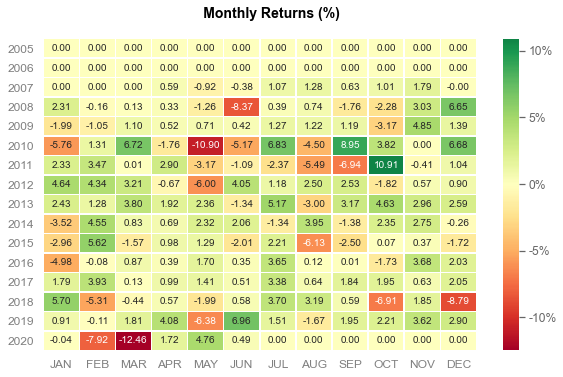

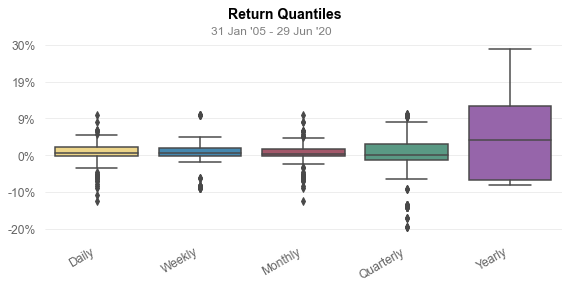

In [81]:
qs.reports.full(returns_qs, benchmark=benchmark)

In [58]:
from tiingo import TiingoClient

start_date = '2000-01-01'
end_date = '2020-12-05'

client = TiingoClient({'api_key' : '9c884b918420c9220dcf832c83a6ba8025711e1e'})

spy_data = client.get_dataframe("SPY",
                                    frequency='monthly',
                                    metric_name="adjClose",
                                    startDate=start_date,
                                    endDate=end_date)

In [66]:
benchmark = spy_data.ffill().pct_change().tz_convert(None)


Start date,2005-01-31
End date,2020-06-29
Total months,8
,Backtest
Annual return,191.644%
Cumulative returns,120.346%
Annual volatility,51.671%
Sharpe ratio,2.34
Calmar ratio,9.87
Stability,0.91
Max drawdown,-19.424%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,19.42,2019-12-31,2020-03-31,NaT,NaN
1,17.77,2011-04-29,2011-09-30,2012-02-29,219
2,16.99,2010-03-31,2010-06-30,2010-12-31,198
3,14.23,2015-07-31,2016-02-29,2017-02-28,413
4,13.51,2018-09-28,2019-05-31,2019-12-31,328


Stress Events,mean,min,max
Lehman,-0.51%,-1.76%,0.74%
US downgrade/European Debt Crisis,-5.49%,-5.49%,-5.49%
Fukushima,0.01%,0.01%,0.01%
EZB IR Event,2.53%,2.53%,2.53%
Aug07,1.28%,1.28%,1.28%
Mar08,0.13%,0.13%,0.13%
Sept08,-1.76%,-1.76%,-1.76%
2009Q1,-1.52%,-1.99%,-1.05%
2009Q2,0.78%,0.52%,1.10%
Apr14,0.69%,0.69%,0.69%


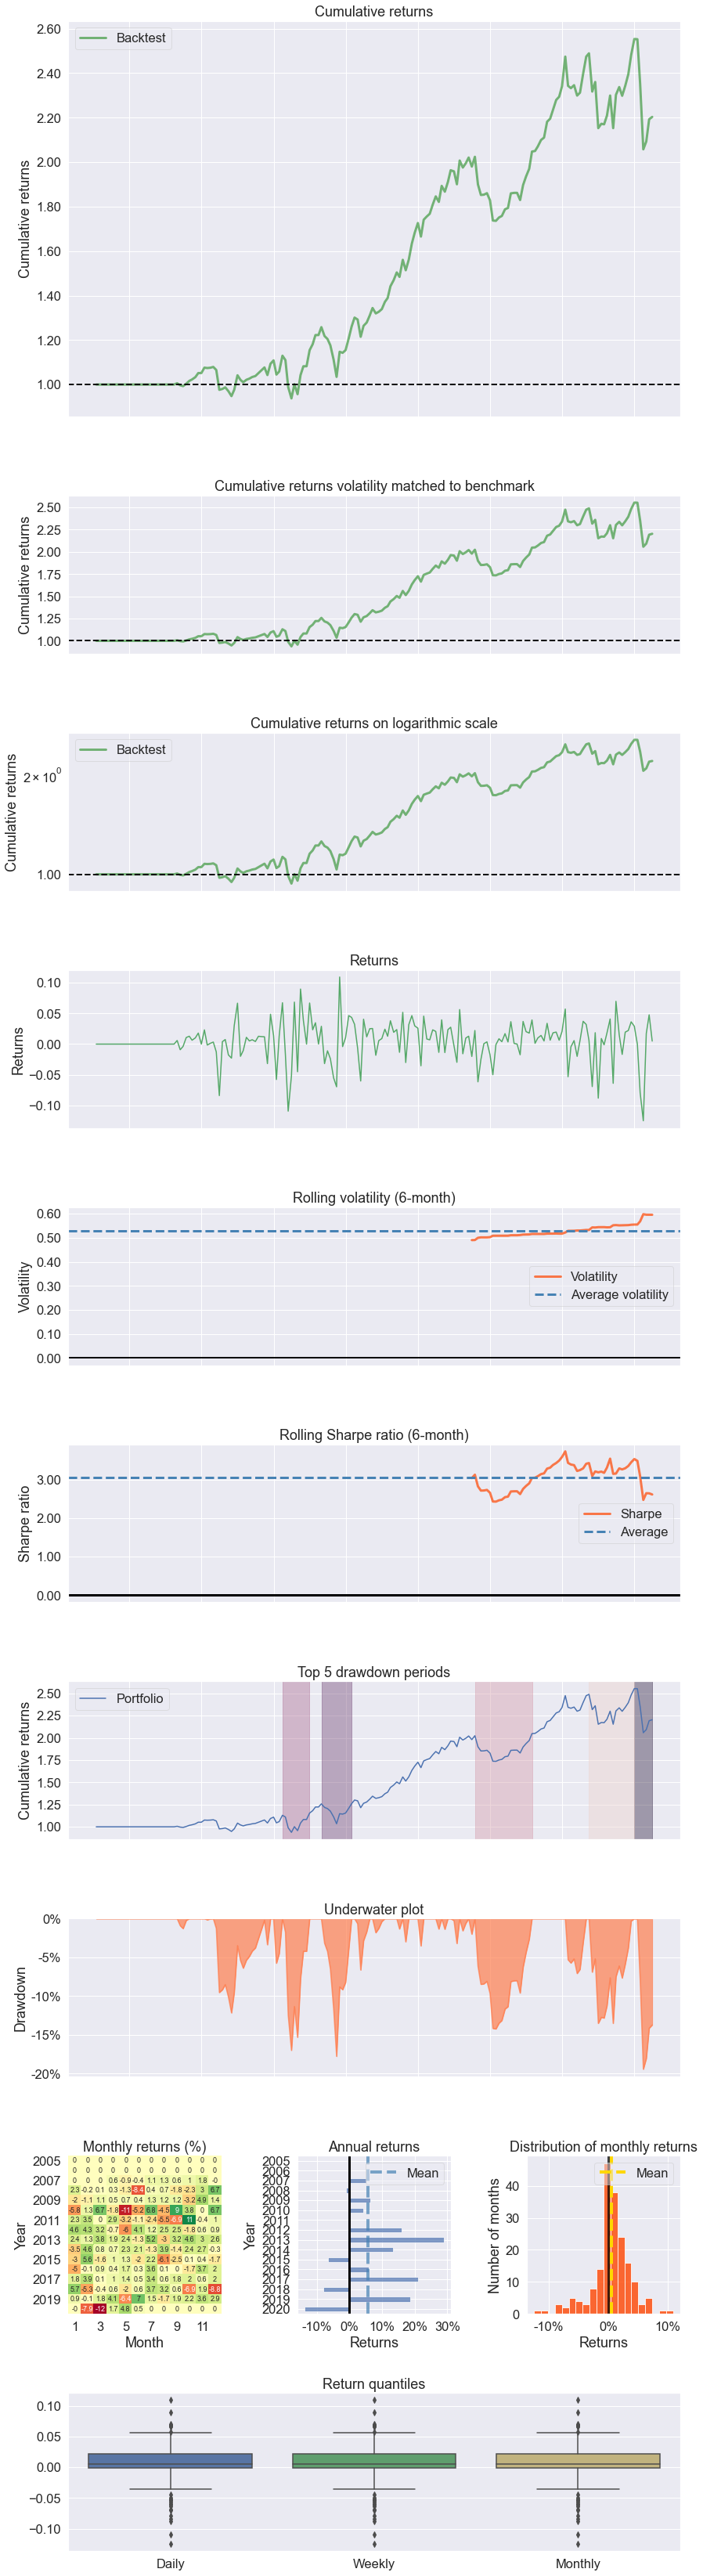

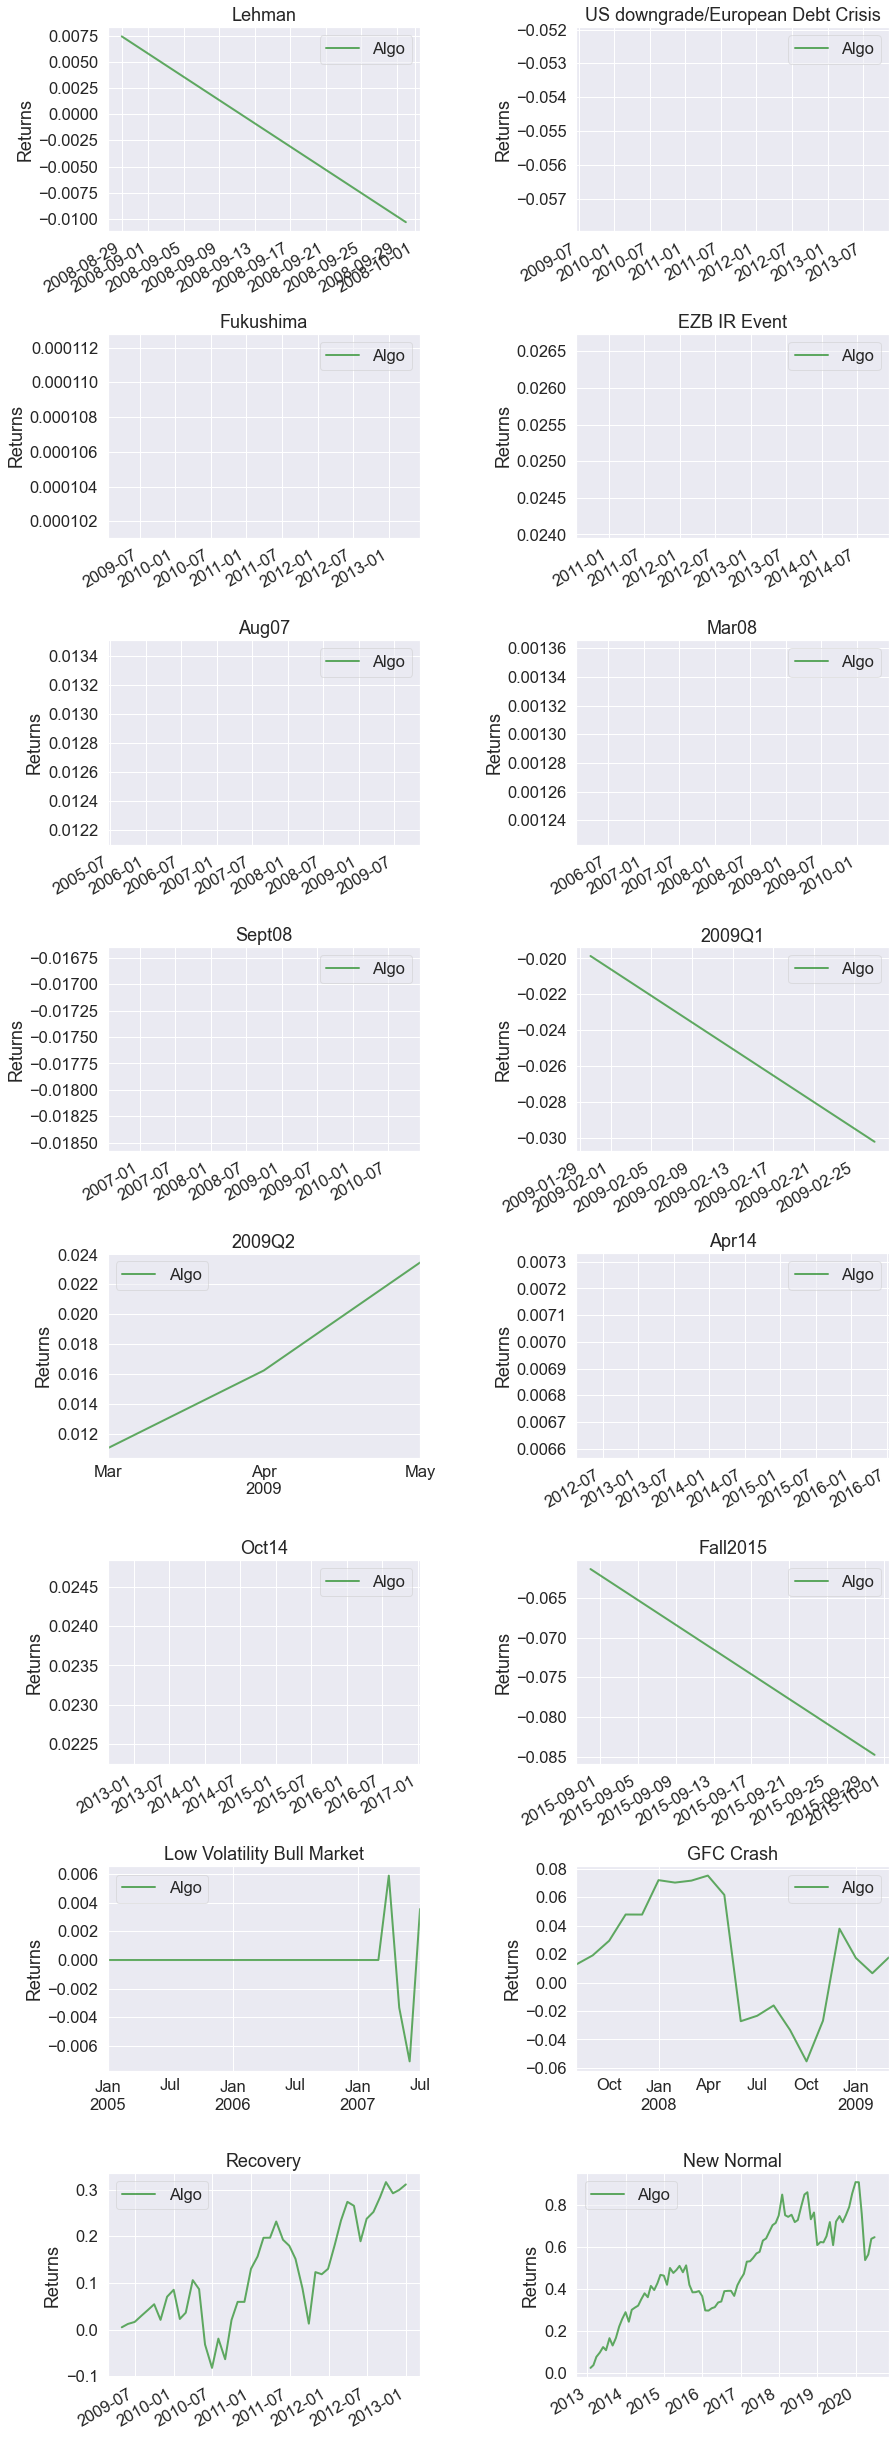

In [82]:
pf.create_full_tear_sheet(returns=returns_qs,transactions=transactions_qs)